In [ ]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
from dotenv import load_dotenv
from pyproj import Transformer
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import folium

/Users/augustinlafond/.pyenv/versions/3.10.6/envs/urban_watch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
load_dotenv()  # charge automatiquement le .env du dossier courant

config = SHConfig()
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")


In [ ]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32631", always_xy=True)
x, y = transformer.transform(5.449351306392167, 43.52807362308702)

print(x)
print(y)

697927.5815822411
4822373.781726923


In [ ]:
half = 1500  # 1500 m = 1.5 km

bbox_utm = BBox(
    bbox=[x-half, y-half, x+half, y+half],
    crs=CRS("EPSG:32631")
)

In [6]:
type(bbox_utm)

sentinelhub.geometry.BBox

In [7]:
# bbox = BBox(bbox=[5.416451, 43.507219, 5.478403, 43.552265], crs=CRS.WGS84)

evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "B08", "B11"],
    output: { bands: 5 }
  };
}
function evaluatePixel(sample) {
  return [sample.B02, sample.B03, sample.B04, sample.B08, sample.B11];
}
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[SentinelHubRequest.input_data(
        DataCollection.SENTINEL2_L2A,
        time_interval=("2025-08-01", "2025-08-30")
    )],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox_utm,
    resolution = (10,10),
    config=config
)


image = request.get_data()[0]

print("Image shape:", image.shape)


Image shape: (300, 300, 5)


In [8]:
B2, B3, B4, B8, B11 = image[:,:,0], image[:,:,1], image[:,:,2], image[:,:,3], image[:,:,4]

# NDVI : (NIR - RED) / (NIR + RED) -- Représente la vegetation
NDVI = (B8 - B4) / (B8 + B4 + 1e-6)

# NDBI : (SWIR - NIR) / (SWIR + NIR). Représente les zones baties
NDBI = (B11 - B8) / (B11 + B8 + 1e-6)


In [ ]:
# Normalisation des bandes.
# CES VARIABLES SERONT LES FEATURES

# image_norm = (image - image.min()) / (image.max() - image.min())

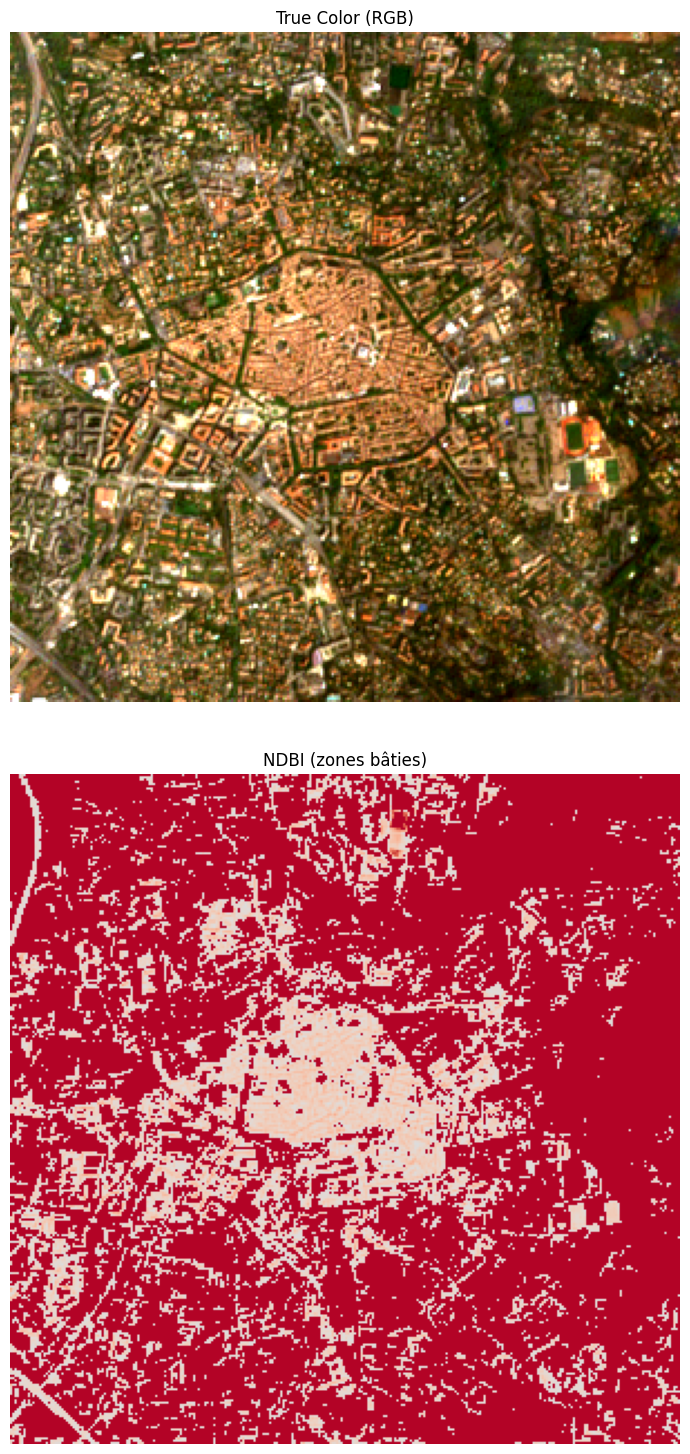

In [9]:
# True color (attention : nécessite une normalisation)
RGB = np.dstack([
    B4,
    B3,
    B2
]).astype(float)

# Normalisation 0-1 pour affichage (important !)
RGB = (RGB - RGB.min()) / (RGB.max() - RGB.min() + 1e-6)

# Normalisation par percentiles (évite que quelques pixels lumineux écrasent tout le contraste)
p2 = np.percentile(RGB, 2)
p98 = np.percentile(RGB, 98)

RGB_stretched = np.clip((RGB - p2) / (p98 - p2), 0, 1)

# Correction gamma (0.7–1.0 recommandé)
gamma = 0.8
RGB_corrected = np.clip(RGB_stretched ** gamma, 0, 1)


# Clip NDBI
NDBI = np.clip(NDBI, -1, 1)

plt.figure(figsize=(7, 15))

# --- TRUE COLOR ---
plt.subplot(2, 1, 1)
plt.title("True Color (RGB)")
plt.imshow(RGB_stretched)
plt.axis("off")

# --- NDBI ---
plt.subplot(2, 1, 2)
plt.title("NDBI (zones bâties)")
plt.imshow(NDBI, cmap="coolwarm", vmin=-1, vmax=1)
plt.axis("off")

plt.tight_layout()

plt.savefig("rgb_ndbi_comparison.png", dpi=300, bbox_inches='tight')

plt.show()